## Read in and setup data

We have the option of reading in and setting up data from two different sources:

* Yelp! Restaurant Reviews
* Amazon Magazine Reviews

### Yelp! Restaurant Reviews

Sometimes it's easiest to test everything out with a small amount of data. The tab delimited [Restaurant Reviews Dataset](http://course.ccs.neu.edu/cs6220/fall2023/homework-5/Restaurant_Reviews.tsv) is a common dataset that is used for natural language tasks that predict the sentiment of a given review.

I've provided a helper script (called [cs6220hw5.py](http://course.ccs.neu.edu/cs6220/fall2023/homework-5/cs6220hw5.py)) that splits the data, standardizes the characters, and weeds out stop words, to parse and clean the text up, which should only be run once.

### Amazon Magazine Reviews

[This is the data for the homework](http://jmcauley.ucsd.edu/data/amazon/index_2014.html), which was released in 2014 and is slightly larger and may take some time to setup. We're only using the Magazine Subscriptions.

### Reference
* Jianmo Ni, Jiacheng Li, Julian McAuley, "*Justifying Recommendations using Distantly-Labeled Reviews and
Fine-Grained Aspects*", In Proceedings of **Empirical Methods in Natural Language Processing**, 2019

In [8]:
#@title Setup the Data (RUN ME)

# Which dataset to download?
dataset = 'magazines' # @param ["restaurant", "magazines"]

# Start with a clean slate
!rm -rf *
!wget -nc http://course.ccs.neu.edu/cs6220/fall2023/homework-5/cs6220hw5.py

# Import everything, including homework code
import numpy as np                                              # numpy array
import pandas as pd                                             # data science
import matplotlib.pyplot as plt                                 # matplotlib
import seaborn as sns                                           # plot style
from sklearn.metrics import confusion_matrix                    # confusion matrix
from sklearn.feature_extraction.text import CountVectorizer     # bag of words
from sklearn.model_selection import train_test_split            # train/test split
from sklearn.preprocessing import MinMaxScaler                  # scale data with min/max
from tqdm import tqdm_notebook as tqdm                          # download data utility
import json                                                     # amazon data in json
from IPython.display import clear_output
import cs6220hw5                                                # import cs6220

if dataset == 'restaurant':
  !wget -nc http://course.ccs.neu.edu/cs6220/fall2023/homework-5/Restaurant_Reviews.tsv

  # Read the CSV data
  data = pd.read_csv('Restaurant_Reviews.tsv', delimiter = '\t', quoting = 3)

else:
  # Download from https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/
  !wget -nc https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Magazine_Subscriptions.json.gz
  !gunzip Magazine_Subscriptions.json.gz

  # Load data in
  reviews = []
  with open('Magazine_Subscriptions.json', 'r') as f:
      for l in tqdm(f):
          r = json.loads(l)
          reviews.append(r)

  # Format the data into Pandas DataFrame
  data = pd.DataFrame.from_records(reviews)[['reviewText', 'overall']]
  print("Initial data size: ", data.size)
  data = data[ data['overall'] != 3.0]
  data = data.rename(columns={"reviewText": "Review"})
  data['Liked'] = 0
  data.loc[data['overall'] > 3, 'Liked'] = 1
  data = data.dropna()

clear_output()
print("Data matrix has shape: ", data.shape)
data.head(10)

Data matrix has shape:  (82687, 3)


,Review,overall,Liked
0,"for computer enthusiast, MaxPC is a welcome si...",5.0,1
1,Thank god this is not a Ziff Davis publication...,5.0,1
3,This beautiful magazine is in itself a work of...,5.0,1
4,A great read every issue.,5.0,1
6,I've read Maximum PC (MPC) for many years. The...,5.0,1
7,We ordered this magazine for our grandson (the...,5.0,1
8,I have subscribed to the nook version for a fe...,4.0,1
9,"I'm old, and so is my computer. Any advice th...",4.0,1
10,"At one time, this was my least favorite comput...",5.0,1
11,I didn't receive a full year. I only receive ...,2.0,0


([<matplotlib.axis.XTick at 0x784446235d50>,
 [Text(0, 0, 'Negative (0)'), Text(1, 0, 'Positive (1)')])

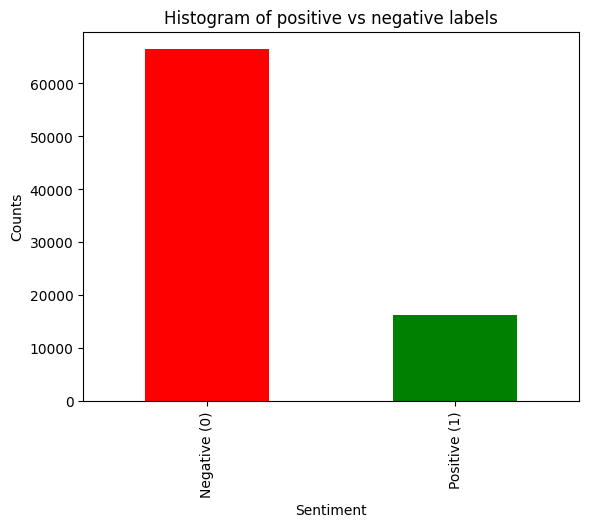

In [9]:
#@title Create a histogram of positive vs negative labels (YOUR CODE HERE)
data['Liked'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title("Histogram of positive vs negative labels")
plt.xlabel("Sentiment")
plt.ylabel("Counts")
plt.xticks([0, 1], ["Negative (0)", "Positive (1)"])

## Preprocess data

Here, you will:

* **Rebalance** the *training data* (leave the test dataset the same).
* **Clean up** the data: remove stopwords, punctuation, verb tense, etc.
* **Assign words** to a "bag of words" where each input feature is a histogram (count) of which words occur in the review.

To clean up the data, I have provided a function in [`cs6220hw5.py`](https://course.ccs.neu.edu/cs6220/fall2023/homework-5/cs6220hw5.py) called `clean_text`. Go ahead and take a look at what it does and explain. This takes a long time to run. What takes the most amount of time? Why?

You will notice in the "bag of words" featurization there are a lot of design decisions.

In [10]:
#@title Create splits & rebalance **training** data (YOUR CODE HERE)

test_size = 0.1 #@param

# <YOUR CODE HERE>

'''
You will need to

1. Split the training and test dataset to be 90 / 10%
2. Rebalance the training dataset so that it's 50/50
   positive / negative
'''
train, test = train_test_split(data, test_size= test_size, random_state=42)
positiveSample = train[train['Liked'] == 1]
negativeSample = train[train['Liked'] == 0]
minSample = min(len(positiveSample), len(negativeSample))
balancedPositiveSample = positiveSample.sample(n=minSample, random_state=42)
balancedNegativeSample = negativeSample.sample(n=minSample, random_state=42)
balancedTrain = pd.concat([balancedPositiveSample, balancedNegativeSample])
balancedTrain = balancedTrain.sample(frac=1, random_state=42)

training_data = balancedTrain
testing_data = test
print("training_data")
print(training_data)
print("testing_data")
print(testing_data)

training_data
                                                  Review  overall  Liked
44792  At first liked her magazine, but find each iss...      2.0      0
85991  This is a nice magazine with high quality arti...      5.0      1
85044  I don't read it but it appears to be dominantl...      1.0      0
7779   WARNING: This magazine has been known to cause...      5.0      1
49103  What was once an entertaining magazine to read...      1.0      0
...                                                  ...      ...    ...
26785  Why does it takes so long to get this item. I ...      1.0      0
77622                        My mom loves this magazine.      5.0      1
64633  The lack of the New Yorker was keeping me from...      5.0      1
64679  This was a great Magazine. Owened by Rodales,t...      1.0      0
87749  Haven't been able to access this subscription ...      1.0      0

[29368 rows x 3 columns]
testing_data
                                                  Review  overall  Like

In [11]:
#@title Clean text with `cs6220hw5.py`. (RUN ME & get some coffee; it takes a while.)

# The following code takes training data in the same format:
#    Review	| Stars |	Liked
training_corpus, testing_corpus = cs6220hw5.clean_text(training_data, testing_data)
print("training_corpus")
print(training_corpus)
print("testing_corpus")
print(testing_corpus)

training_corpus
44792    first like magazin find issu alway comment sty...
85991    nice magazin high qualiti articl nice photo th...
85044    read appear dominantli advertis bought grandso...
7779     warn magazin known caus vacat oper heavi machi...
49103    entertain magazin read join cesspool polit act...
                               ...                        
26785    take long get item could order anoth month set...
77622                                     mom love magazin
64633    lack new yorker keep buy kindl avail bought on...
64679    great magazin owen rodal fw media still get sa...
87749    abl access subscript sinc first month ipad app...
Name: Review, Length: 29368, dtype: object
testing_corpus
80651    especi christian worldview write sound fact we...
4870     enjoy look magazin prefer countri live casual ...
88793                                      favorit magazin
86035    look forward issu give neat stori southern art...
60132    bought coupon meet expect bad ma

In [18]:
#@title Featurize into Bag of Words (Example Code)

# creating the count vectorizer model with max_features
vocab_size = 200                #@param
test_size = 0.1                 #@param
minmax_scale = True             #@param

cv = CountVectorizer(max_features = vocab_size)
x_train = cv.fit_transform(training_corpus).toarray()
y_train = np.array(training_data['Liked'])

x_test = cv.transform(testing_corpus).toarray()
y_test = np.array(testing_data['Liked'])

if minmax_scale:
  mm = MinMaxScaler()
  x_train = mm.fit_transform(x_train)
  x_test = mm.transform(x_test)

# Run all the algorithms

Play around with some thresholds. Because your evaluation dataset has the original distribution, play with that parameter. For each algorithm, print out:

* Accuracy
* Confusion Matrix
* Precision / Recall AUC

In [20]:
#@title Naive Bayes, Random Forest, Decision Tree Classifier, Logistic Regression (YOUR CODE HERE)

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, auc

# YOUR CODE HERE
# Naive Bayes
naiveBayes = GaussianNB()
naiveBayes.fit(x_train, y_train)
naiveBayesPredict = naiveBayes.predict(x_test)
naiveBayesPredictTrain = naiveBayes.predict(x_train)

# Random Forest
randomForest = RandomForestClassifier(random_state=42)
randomForest.fit(x_train, y_train)
randomForestPredict = randomForest.predict(x_test)
randomForestPredictTrain = randomForest.predict(x_train)

# Decision Tree Classifier
decisionTree = DecisionTreeClassifier(random_state=42)
decisionTree.fit(x_train, y_train)
decisionTreePredict = decisionTree.predict(x_test)
decisionTreePredictTrain = decisionTree.predict(x_train)

# Logistic Regression
logisticRegression = LogisticRegression(random_state=42)
logisticRegression.fit(x_train, y_train)
logisticRegressionPredict = logisticRegression.predict(x_test)
logisticRegressionPredictTrain = logisticRegression.predict(x_train)

def printEvaluation(modelName, predictions, predictions_train):
  accuracy = accuracy_score(y_test, predictions)
  accuracy_train = accuracy_score(y_train, predictions_train)
  confusionMatrix = confusion_matrix(y_test, predictions)
  precision, recall, _ = precision_recall_curve(y_test, predictions)
  precisionRecallAUC = auc(recall, precision)
  print(f"-----{modelName}-----")
  print("Accuracy: ", accuracy)
  print("Confusion Matrix: ", confusionMatrix)
  print("Precision / Recall AUC: ", precisionRecallAUC)
  if accuracy_train - accuracy > 0.1:
    print("Accuracy of training data:", accuracy_train)
    print("The Model is overfitted")

printEvaluation("Naive Bayes", naiveBayesPredict, naiveBayesPredictTrain)
printEvaluation("Random Forest", randomForestPredict, randomForestPredictTrain)
printEvaluation("Decision Tree Classifier", decisionTreePredict, decisionTreePredictTrain)
printEvaluation("Logistic Regression", logisticRegressionPredict, logisticRegressionPredictTrain)

-----Naive Bayes-----
Accuracy:  0.8085620994074253
Confusion Matrix:  [[ 841  726]
 [ 857 5845]]
Precision / Recall AUC:  0.9326411791042538
-----Random Forest-----
Accuracy:  0.8075946305478292
Confusion Matrix:  [[1350  217]
 [1374 5328]]
Precision / Recall AUC:  0.9610074962666943
Accuracy of training data: 0.9765731408335603
The Model is overfitted
-----Decision Tree Classifier-----
Accuracy:  0.7476115612528722
Confusion Matrix:  [[1202  365]
 [1722 4980]]
Precision / Recall AUC:  0.9415106624475881
Accuracy of training data: 0.9765731408335603
The Model is overfitted
-----Logistic Regression-----
Accuracy:  0.815576248639497
Confusion Matrix:  [[1306  261]
 [1264 5438]]
Precision / Recall AUC:  0.9592310768478249
